In [249]:
!pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [250]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn

## I. MNIST Data

### Exercice 1 : Loading Data

In [251]:
import torch
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

from torchvision.datasets import MNIST
from torchvision import transforms

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

1)Create a function iid_split. This function should take a dataset, nb_nodes, n_samples_per_node, batch_size, and shuffle as parameters. The goal is to divide the dataset into nb_nodes subsets (i.i.d.) and load each subset using PyTorch's DataLoader with the specified batch_size and shuffle, and then return a list of these DataLoaders.

Steps:
Load Data: Use DataLoader to load n_samples_per_node from the dataset with shuffle.  
Split Data: Divide the loaded data into nb_nodes i.i.d subsets, create a DataLoader for each, and append it to a list.   
Return List: Return the list of DataLoaders created.   

In [252]:
def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
    data_loaders = []
    for node in range(nb_nodes):
        start_idx = node * n_samples_per_node
        end_idx = start_idx + n_samples_per_node
        subset = Subset(dataset, list(range(start_idx, end_idx)))
        data_loader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
        data_loaders.append(data_loader)
    
    return data_loaders

2) Create a function non_iid_split, designed to divide a dataset non-i.i.d. It will receive parameters: dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, and shuffle_digits.

Steps:
Arrange Digits: Optionally shuffle digits and fairly split them among nb_nodes.  
Load Data: Utilize DataLoader to load nb_nodes*n_samples_per_node samples, considering the shuffle parameter.   
Split Data and Return: Create DataLoaders for each node containing samples with corresponding digits and append them to a list.   

In [253]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False,num_classes=10):
    # num_classes will be useful for exercise on medical data
    assert(nb_nodes>0 and nb_nodes<=num_classes)
    digits=torch.arange(num_classes) if shuffle_digits==False else torch.randperm(10, generator=torch.Generator().manual_seed(0))

    
    fairly_digits = torch.chunk(digits, nb_nodes)
    loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=nb_nodes*n_samples_per_node,
                                        shuffle=False)
    
    
    images_train, labels_train = next(iter(loader))
    dataloaders=list()
    # print(fairly_digits)
    for i in range(nb_nodes):
        indexes = []
        for index, label in enumerate(labels_train): 
            if(label.item() in fairly_digits[i]):
                indexes.append(index)
        subset = Subset(dataset, indexes)
        
        node_loader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
        
        dataloaders.append(node_loader)
        
    return dataloaders

3) Create a function get_MNIST, that fetches the MNIST dataset and utilizes either iid_split or non_iid_split to return train and test DataLoaders. The parameters are type ("iid" or "non_iid"), n_samples_train, n_samples_test, n_clients, batch_size, and shuffle.

Steps:
Load MNIST Dataset: Utilize the MNIST dataset from PyTorch datasets for both train and test.  
Apply Split Function: Depending on the type parameter, apply either iid_split or non_iid_split to the loaded datasets.   
Return DataLoaders: Return the created train and test DataLoaders lists.  


In [254]:
def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True,num_classes=10):
    
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = MNIST('./mnist',download=True,transform=transform,train=True)
    test_dataset = MNIST('./mnist',download=True,transform=transform,train=False)
    train_loaders,test_loaders = [],[]
    if(type=="iid"):
        train_loaders = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    if(type=="non_iid"):
        train_loaders = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle,num_classes=num_classes)
        test_loaders = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle,num_classes=num_classes)
    return train_loaders,test_loaders


4) Use get_MNIST to get mnist_iid_train and mnist_iid_test dataloaders.

In [255]:
mnist_iid_train,mnist_iid_test  = get_MNIST()

5) Giving the following function plot_samples for iid data. Plot image samples of client 1, 2 and 3.

In [256]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    n_rows = int((n_examples-1) / 5) +1
    fig = plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title:
        plt.suptitle(title)
    X, y= data
    # print(f'{X.size()=}')
    for idx in range(n_examples):

        ax = fig.add_subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")
        # print(y[idx])

    if plot_name!="":
        fig.savefig(plot_name+".png")

    plt.tight_layout()
    plt.show()

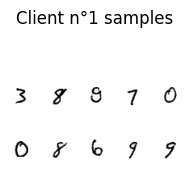

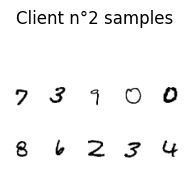

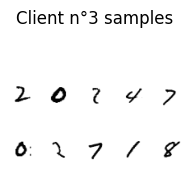

In [257]:
for i,loader in enumerate(mnist_iid_train):
    data = (next(iter(loader)))
    plot_samples(data=data,channel=0,title=f'Client n°{i+1} samples',n_examples=10)

6) Plot samples this time for non_iid data for 3 clients.

In [258]:
mnist_non_iid_train, mnist_non_iid_test = get_MNIST(type="non_iid",n_clients=3)

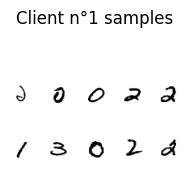

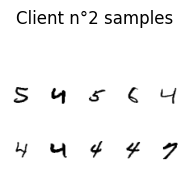

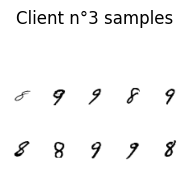

In [259]:
for i,loader in enumerate(mnist_non_iid_train):
    data = (next(iter(loader)))
    
    plot_samples(data=data,channel=0,title=f'Client n°{i+1} samples',n_examples=10)

### Exercice 2 : FedAvg and FedProx Implementation

Here is a simple CNN.

In [260]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_0 = CNN()
X,y = next(iter(mnist_iid_train[0]))
model_0(X).size(),y.size()

(torch.Size([25, 10]), torch.Size([25]))

1) Create a function difference_models_norm_2(model_1, model_2) which take two models, get models parameters and returns the sum of the square differences of models parameters.





In [261]:
def difference_models_norm_2(model_1, model_2):
    params_1 = list(model_1.parameters())
    params_2 = list(model_2.parameters())
    sum_squared_diff = 0.0

    
    if len(params_1) != len(params_2):
        raise ValueError("The models must have the same number of parameters.")

    for p1, p2 in zip(params_1, params_2):
        diff = p1 - p2
        sum_squared_diff += torch.sum(diff**2)

    return sum_squared_diff

Here is the function to perform one epoch of training data.

In [262]:
def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""

    total_loss=0

    for idx, (features,labels) in enumerate(train_data):

        optimizer.zero_grad()

        predictions= model(features)

        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss

        loss.backward()
        optimizer.step()

    return total_loss/(idx+1)

2) Create a function local_learning which perform a local training of a model sent. We need to precise number of epochs needed to be performed locally. Use previous function defined.

Return the local_loss compute during local training.

In [263]:

def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):

    ### Copy model to a new variable ###
    model_cpy = deepcopy(model)

    for epoch in range(epochs):
        local_loss=train_step(model,model_cpy,mu,optimizer,train_data, loss_f)

    return float(local_loss.detach().numpy())

We defined 4 others usefull functions :
- loss_classifier :
- loss_dataset :
- accuracy_dataset :
- set_to_zero_model_weights :

Take time to read it.

In [264]:
def loss_classifier(predictions,labels):

    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")

    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0

    for idx,(features,labels) in enumerate(dataset):

        predictions= model(features)
        loss+=loss_f(predictions,labels)

    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""

    correct=0

    for features,labels in iter(dataset):

        predictions= model(features)

        _,predicted=predictions.max(1,keepdim=True)

        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()

    accuracy = 100*correct/len(dataset.dataset)

    return accuracy

def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

3) Defined a function average_models, which as it is written average parameters of a list of models to create a new model.


In [265]:
def average_models(model, clients_models_hist:list , weights:list):


    """Creates the new model of a given iteration with the models of the other
    clients"""
    # print(clients_models_hist)
    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):

        for idx, layer_weights in enumerate(new_model.parameters()):
            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)
    
    return new_model

4) We will now code a function to perform FedProx.

In [266]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0,
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """

    loss_f=loss_classifier

    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)


    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach())
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy()
        for tens_param in list(model.parameters())]]
    models_hist = []


    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')

    for i in range(n_iter):

        clients_params=[]
        clients_models=[]
        clients_losses=[]

        for k in range(K):

            local_model=deepcopy(model)#torch.load(filename)
            # Define optimizer for local_model, don't forget the learning rate !
            local_optimizer=optim.SGD(local_model.parameters(), lr=lr)
            # compute local_loss by performing learning steps on the current model
            local_loss= local_learning(model=local_model, mu=mu, optimizer=local_optimizer, train_data=training_sets[k], epochs=epochs, loss_f=loss_f)

            clients_losses.append(local_loss)

            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)
            clients_models.append(deepcopy(local_model))


        #CREATE THE NEW GLOBAL MODEL
        # Create new global model by avering all locals models
        model = average_models(model,clients_params,weights)
        models_hist.append(clients_params)

        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach())
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')


        server_hist.append([tens_param.detach().cpu().numpy()
            for tens_param in list(model.parameters())])

        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay

    return model, loss_hist, acc_hist

###  Exercice 3 : iid data

#### Fed training with FedAvg

1) With FedProx compute a FedAvg on iid data.

In [267]:
fpx_model, loss_hist, acc_hist = FedProx(model_0,mnist_iid_train,10,mnist_iid_test,mu=0)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.2993899186452227 Server Test Accuracy: 18.0
====> i: 1 Loss: 2.2780654430389404 Server Test Accuracy: 27.999999999999996
====> i: 2 Loss: 2.2512690226236978 Server Test Accuracy: 29.333333333333332
====> i: 3 Loss: 2.2085551420847573 Server Test Accuracy: 34.33333333333333
====> i: 4 Loss: 2.12956960995992 Server Test Accuracy: 43.33333333333333
====> i: 5 Loss: 1.9636143048604326 Server Test Accuracy: 51.666666666666664
====> i: 6 Loss: 1.6273079315821328 Server Test Accuracy: 58.33333333333333
====> i: 7 Loss: 1.1793718735376992 Server Test Accuracy: 66.33333333333333
====> i: 8 Loss: 0.8461526036262512 Server Test Accuracy: 72.33333333333333
====> i: 9 Loss: 0.6593909859657288 Server Test Accuracy: 76.33333333333333
====> i: 10 Loss: 0.5655072629451752 Server Test Accuracy: 79.33333333333333


2) Define a function plot_accuracy_loss to plot accuracy and loss of performed FedAvg for the 3 different clients.

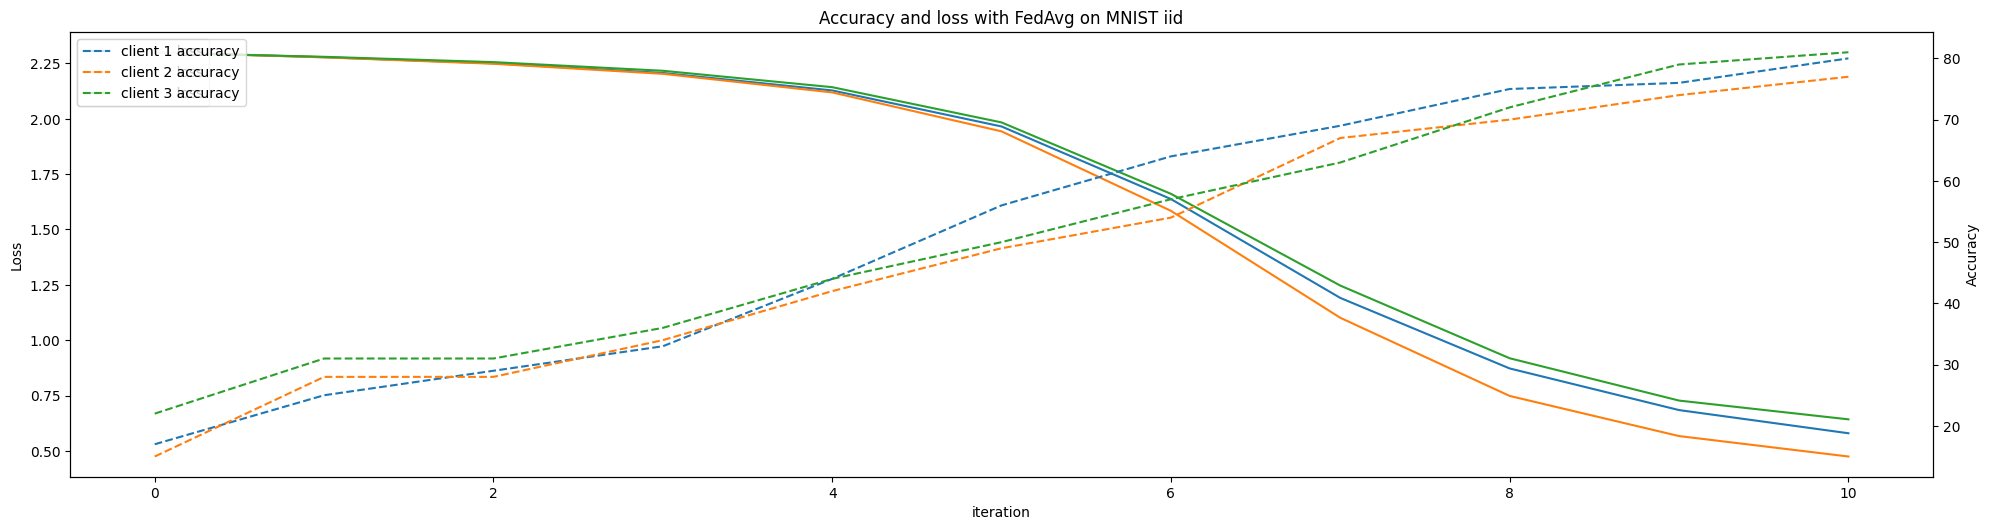

In [268]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
    n_ax = 2
    fig_ratio = 10
    loss_hist_array = np.array(loss_hist)
    acc_hist_array = np.array(acc_hist)
    fig = plt.figure(figsize=(fig_ratio*n_ax,fig_ratio))
    ax1 = fig.add_subplot(n_ax,1,1)
    ax1.set_title(title)
    ax2 = ax1.twinx()
    for i in range(loss_hist_array.shape[1]):
        
        ax1.plot(loss_hist_array[:,i],label=f'client {i+1} loss')
        
        ax2.plot(acc_hist_array[:,i],label=f'client {i+1} accuracy',linestyle='dashed')
        
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('Loss evolution')
    
    
    ax2.set_ylabel('Accuracy')
    ax1.set_ylabel('Loss')
    
    ax1.legend(loc='upper left')
    ax2.legend()
    plt.tight_layout()
    plt.show()
    
plot_acc_loss('Accuracy and loss with FedAvg on MNIST iid',loss_hist,acc_hist )

#### FedPRox

3) Do the same as for 1) and 2).
You can take 2 local epochs, a learning rate of 0.1, mu = 0.3 and 10 iterations.

In [269]:
mu=0.3
fpx_model, loss_hist, acc_hist = FedProx(model_0,mnist_iid_train,10,mnist_iid_test,mu=mu,epochs=2,lr=0.1)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.2993899186452227 Server Test Accuracy: 18.0
====> i: 1 Loss: 2.2131008307139077 Server Test Accuracy: 42.666666666666664
====> i: 2 Loss: 1.7290995915730794 Server Test Accuracy: 44.666666666666664
====> i: 3 Loss: 0.9759122729301453 Server Test Accuracy: 67.0
====> i: 4 Loss: 0.5725067456563313 Server Test Accuracy: 79.66666666666666
====> i: 5 Loss: 0.45602244138717646 Server Test Accuracy: 81.66666666666666
====> i: 6 Loss: 0.38580585519472754 Server Test Accuracy: 84.33333333333333
====> i: 7 Loss: 0.3732427954673767 Server Test Accuracy: 82.0
====> i: 8 Loss: 0.2698371559381485 Server Test Accuracy: 88.33333333333333
====> i: 9 Loss: 0.22402034203211463 Server Test Accuracy: 88.0
====> i: 10 Loss: 0.18082244197527564 Server Test Accuracy: 90.33333333333333


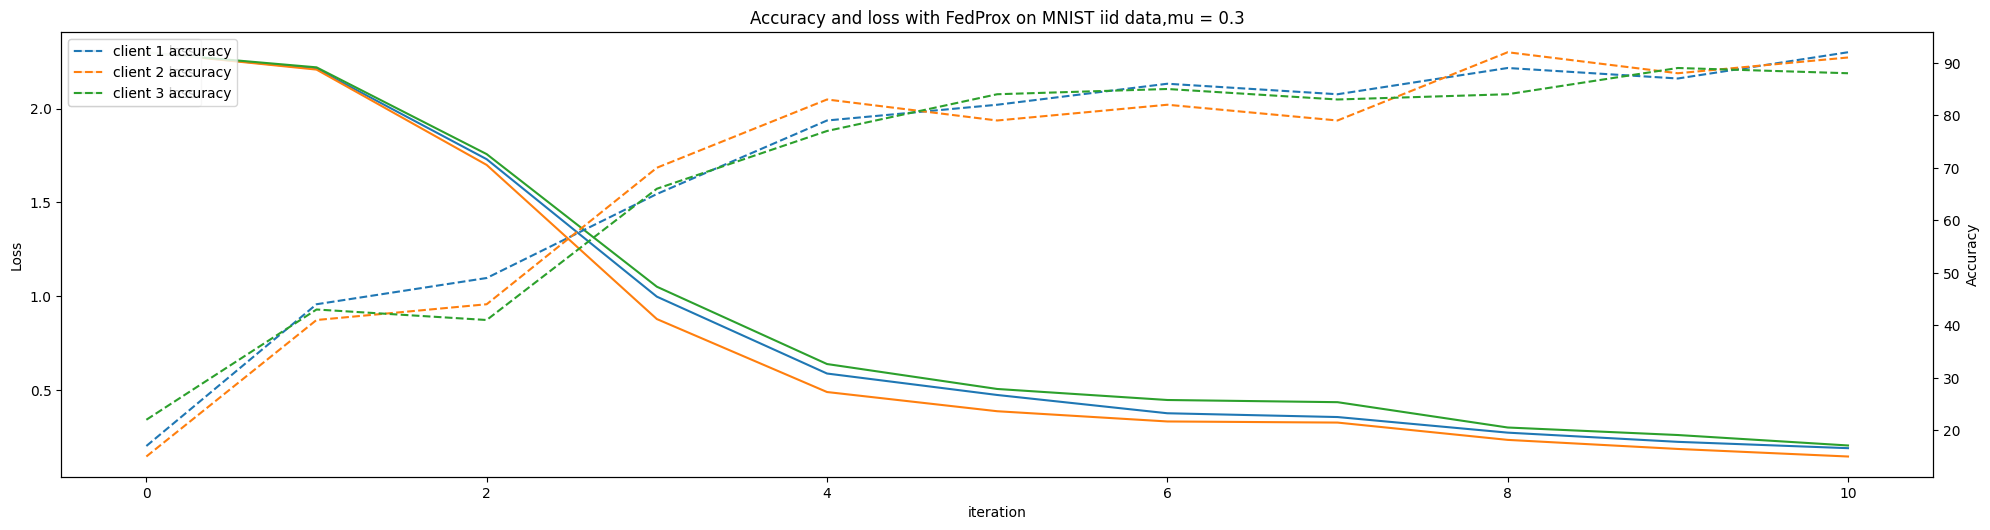

In [270]:
plot_acc_loss(f'Accuracy and loss with FedProx on MNIST iid data,{mu = }',loss_hist,acc_hist )

4) What do you observe ?

We can observe that all the client models are converging smoothly in the same way either on accuracy or loss.

### Exercice 4 : Non iid data

1) Perform a FedAvg on data and plot accuracy and loss
2) Do the same for a FedProx.

Clients' weights: [0.43333333333333335, 0.37666666666666665, 0.19]
====> i: 0 Loss: 2.2985161058108012 Server Test Accuracy: 19.338842975206614
====> i: 1 Loss: 2.271332800388336 Server Test Accuracy: 34.35774904469919
====> i: 2 Loss: 2.18865966240565 Server Test Accuracy: 32.60859326401848
====> i: 3 Loss: 1.9484016338984171 Server Test Accuracy: 46.3900293255132
====> i: 4 Loss: 1.7210390822092692 Server Test Accuracy: 40.16120145738914
====> i: 5 Loss: 1.3833741188049316 Server Test Accuracy: 51.0232604638763
====> i: 6 Loss: 1.1978397468725839 Server Test Accuracy: 61.047454012263394
====> i: 7 Loss: 1.0398264700174331 Server Test Accuracy: 61.05698480405225
====> i: 8 Loss: 0.980892376502355 Server Test Accuracy: 60.91631120590064
====> i: 9 Loss: 0.874415243268013 Server Test Accuracy: 65.51152581533812
====> i: 10 Loss: 0.9407553684711456 Server Test Accuracy: 60.86855060872655


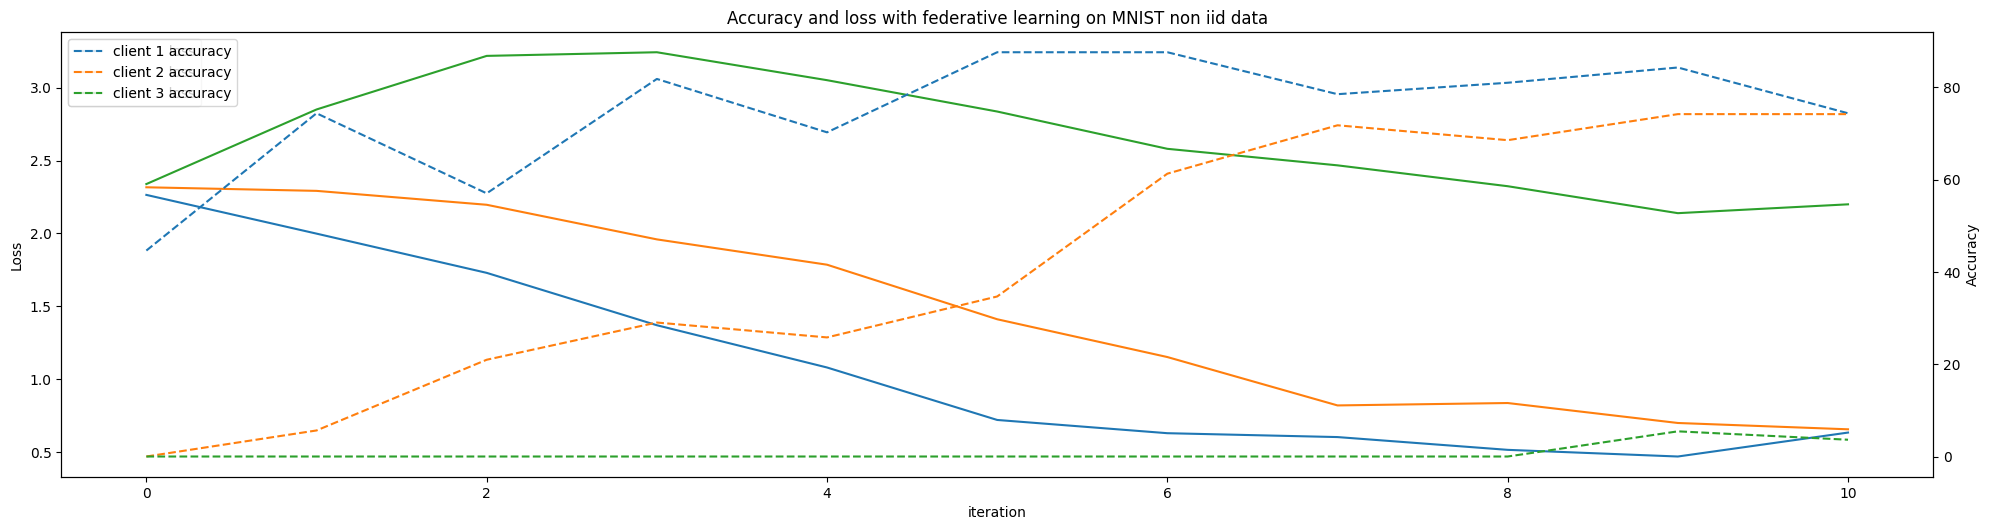

In [271]:
fpx_model, loss_hist, acc_hist = FedProx(model_0,mnist_non_iid_train,10,mnist_non_iid_test)
plot_acc_loss('Accuracy and loss with federative learning on MNIST non iid data',loss_hist,acc_hist )

Clients' weights: [0.43333333333333335, 0.37666666666666665, 0.19]
====> i: 0 Loss: 2.299402587413788 Server Test Accuracy: 19.338842975206614
====> i: 1 Loss: 2.277160440286001 Server Test Accuracy: 22.920110192837466
====> i: 2 Loss: 2.200653490225474 Server Test Accuracy: 45.67377588198703
====> i: 3 Loss: 2.052002588907878 Server Test Accuracy: 34.57184750733138
====> i: 4 Loss: 1.7241813866297404 Server Test Accuracy: 45.705722918332896
====> i: 5 Loss: 1.5138803259531657 Server Test Accuracy: 43.090109304185546
====> i: 6 Loss: 1.2816934446493784 Server Test Accuracy: 58.31358304452146
====> i: 7 Loss: 1.1188527117172877 Server Test Accuracy: 58.45425664267306
====> i: 8 Loss: 0.9820479357242584 Server Test Accuracy: 64.44321514262863
====> i: 9 Loss: 0.9210169867674509 Server Test Accuracy: 64.32181640451435
====> i: 10 Loss: 0.8709152305126191 Server Test Accuracy: 65.8696525371012


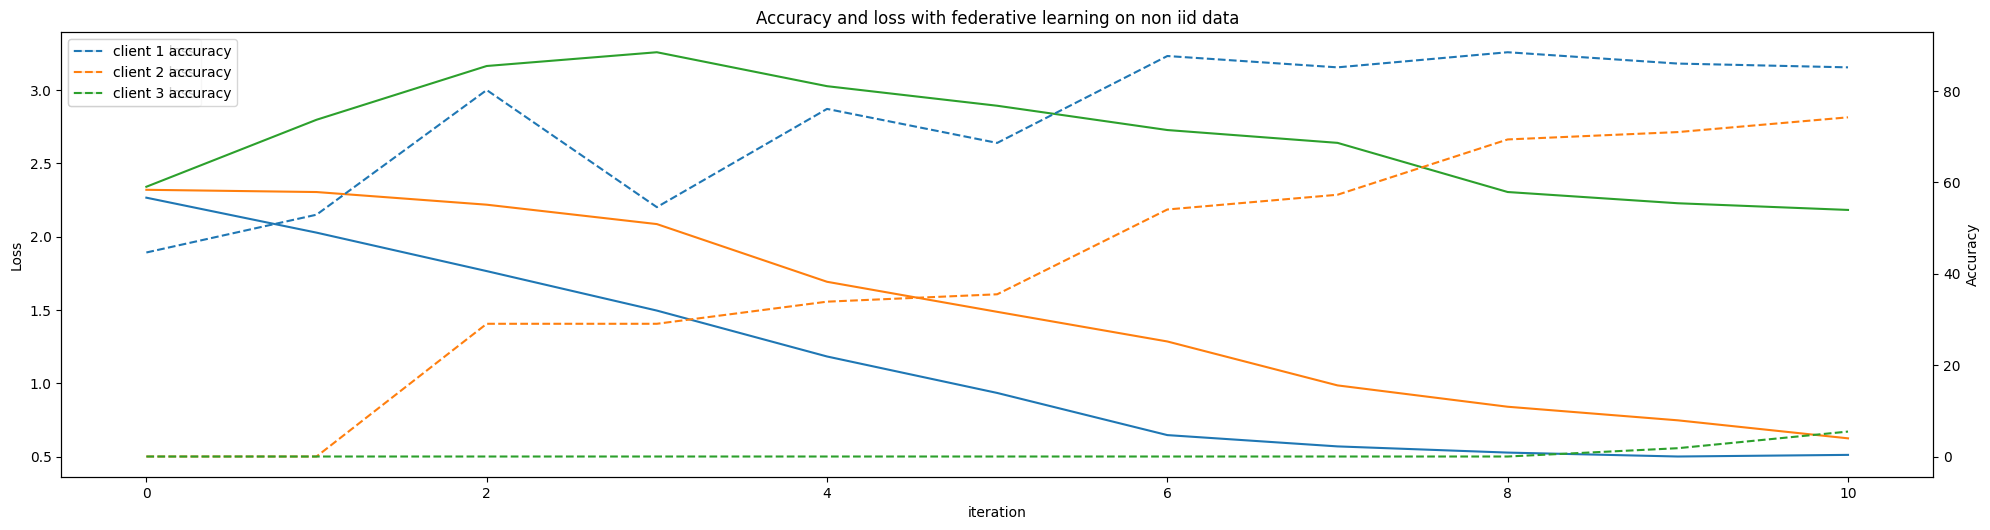

In [272]:
mu = 0.3
fpx_model, loss_hist, acc_hist = FedProx(model_0,mnist_non_iid_train,10,mnist_non_iid_test,mu=0.3)
plot_acc_loss('Accuracy and loss with federative learning on non iid data',loss_hist,acc_hist )

2) What do you observe ?

We can see an evolution of loss and accuracy much more chaotic and unstable and unequal for clients.

## II. Medical Data

### Exercice 5 : medmnist

For medical datasets we will use medmnist package.  
Medmnist is large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D : https://medmnist.com/

In [273]:
! pip install medmnist

Import medmnist

In [274]:
import medmnist

You can list all available datasets with this command

In [275]:
!python -m medmnist available

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist
	chestmnist
	dermamnist
	octmnist
	pneumoniamnist
	retinamnist
	breastmnist
	bloodmnist
	tissuemnist
	organamnist
	organcmnist
	organsmnist
	organmnist3d
	nodulemnist3d
	adrenalmnist3d
	fracturemnist3d
	vesselmnist3d
	synapsemnist3d


We will use BloodMNIST for the following exercices. BloodMnist is a dataset with 8 categories of blood cells capture by microscope.

1. Import from medmnsit BloodMNIST

In [276]:
from medmnist import BloodMNIST

In [277]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

2. Create a preprocessing pipeline for data, transforms it into Tensor and then normalize it with a mean of 0.5 and standard deviation of 0.5 also.

In [278]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

3. Create a train dataset and test dataset from data and apply previous preprocessing pipeline. You can use DataClass from pytorch to create datasets.

In [279]:
download=True
train_dataset = BloodMNIST(split='train', transform=data_transform, download=download)
test_dataset = BloodMNIST(split='test', transform=data_transform, download=download)


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


4. Just to understand data print the 2 datasets to see differences with previous MNIST data.

In [280]:
print(train_dataset)
print(test_dataset)
# plot_samples(next(iter(bm_train_loader)),channel =0,title='Blood MNIST train set', plot_name="bm-train", n_examples =20)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0
Datas

Instead of 1 channel in MNIST there are 3 channels, because we are working on RGB images. Also we can see that number of class for BloodMNIST is 8.

5. Create a data loader for train data and test dat, you can use a batch size of 128 and shuffle data.

In [281]:
bm_train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
bm_test_loader = DataLoader(dataset=test_dataset, batch_size= 128, shuffle=False)

6. Modify previous functions non_iid_split, iid_split, get_MNIST and plot_samples to work with new data.  
a. non_iid_split : this time there are only 8 classes   
b. iid_split : nothing really changed  
c. get_MNIST : Like in 3. use train and test datasets with the preprocessing pipeline we defined previously.  
d. plot_samples : Make it work for this new images. Also try to print to which classes belong every images, to see later if your iid_split and non_iid_split work well.

 For `non_iid_split` and `get_MNIST` and  We just add the parameter `num_classe` in order to both adapt `MNIST` and `BloodMNIST`. 

In [282]:
def get_BloodMNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True,num_classes=8):
    data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = BloodMNIST(split='train', transform=data_transform, download=True)
    test_dataset = BloodMNIST(split='test', transform=data_transform, download=True)
    train_loaders,test_loaders = [],[]
    if(type=="iid"):
        train_loaders = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    if(type=="non_iid"):
        train_loaders = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle,num_classes=num_classes)
        test_loaders = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle,num_classes=num_classes)
    return train_loaders,test_loaders

In [283]:
bmnist_iid_train,bmnist_iid_test  = get_BloodMNIST(type="iid")
bmnist_non_iid_train,bmnist_non_iid_test  = get_BloodMNIST(type="non_iid")

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


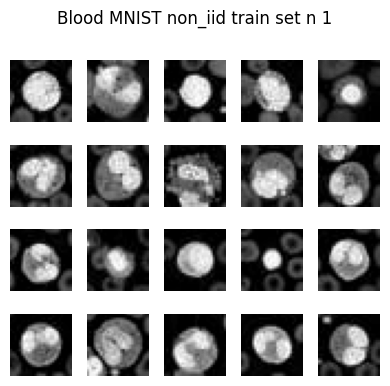

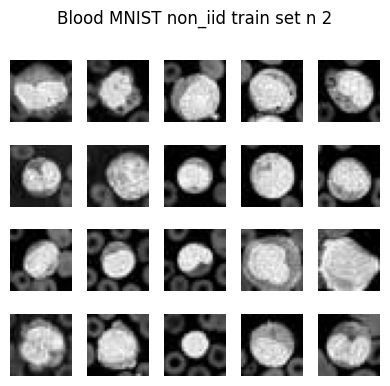

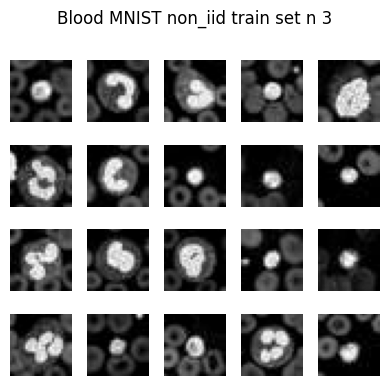

In [284]:
for i,loader in enumerate(bmnist_non_iid_train):
    data = (next(iter(loader)))
    plot_samples(data,channel =0,title=f'Blood MNIST non_iid train set n {i+1}', plot_name="bm-train-non-iid", n_examples =20)

### Exercice 6 : Use federated learning on medical data

### IID data

1. Load train data and test data for 3 clients into IID datasets.

In [285]:
bmnist_iid_train,bmnist_iid_test  = get_BloodMNIST(type="iid")
#bmnist_non_iid_train,bmnist_non_iid_test  = get_BloodMNIST(type="non_iid")

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


2. plost samples with corresponding function.

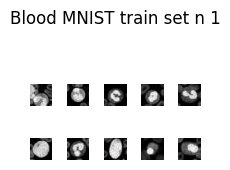

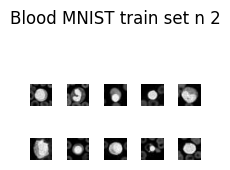

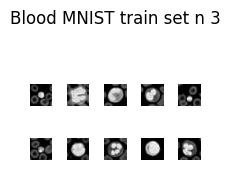

In [286]:
for i,loader in enumerate(bmnist_iid_train):
    data = (next(iter(loader)))
    plot_samples(data,channel =0,title=f'Blood MNIST train set n {i+1}', plot_name="bm-train-iid", n_examples =10)

3. Design a convlution neural network to perform classification.  
You can try to adpat previous convolution network.   
Or also you can try this type of architecture :  
- A first 2D convolution layer with an output_channels of 16, a BatchNormalisation and a Relu activation   
- A second 2D conv layer identical but with a MaxPooling layer after  
- A 3rd conv layer with an output_channels of 64, a BatchNormalisation and a Relu activation again.
- A 4rd layer identical to 3rd one.  
- A 5rd layer identical but with a MaxPooling added. Don't forget to use padding to not loose informations from corners.
- Finally add dense layers to perform classification. You can add regularization layers between dropout for example.



In [287]:

class CNN_2(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, 1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 16, 5, 1)
        self.batch_norm2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(16, 64, 5, 1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 64, 5, 1)
        self.batch_norm4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 64, 5, 1,padding=2)
        self.batch_norm5 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64, 500)
        self.fc2 = nn.Linear(500, 8)

    def forward(self, x):
        x = self.batch_norm1(self.conv1(x))
        x = F.relu(x)
        
        x = self.batch_norm2(self.conv2(x))
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = self.batch_norm3(self.conv3(x))
        x = F.relu(x)
        
        x = self.batch_norm4(self.conv4(x))
        x = F.relu(x)
        
        x = self.batch_norm5(self.conv5(x))
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        #print(x.size())
        x = x.view(-1,64)
        #print(x.size())
        x = F.relu(self.fc1(x))
        #print(x.size())
        x = self.fc2(x)

        return x

model_0 = CNN_2()
X,y = next(iter(bmnist_iid_train[0]))


model_0(X).size(), y.size()

(torch.Size([25, 8]), torch.Size([25, 1]))

### Fed training with FedAvg

4. Perform a FedAvg with same parameters as for MNIST datasets. Use 3 clients, etc. Try to run more iterations.

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.043397506078084 Server Test Accuracy: 21.333333333333332
====> i: 1 Loss: 1.3005555470784504 Server Test Accuracy: 45.666666666666664
====> i: 2 Loss: 0.7764794826507568 Server Test Accuracy: 69.66666666666666
====> i: 3 Loss: 0.6393657128016154 Server Test Accuracy: 72.0
====> i: 4 Loss: 0.5423489014307658 Server Test Accuracy: 73.33333333333333
====> i: 5 Loss: 0.5116393566131592 Server Test Accuracy: 77.33333333333333
====> i: 6 Loss: 0.5075410803159077 Server Test Accuracy: 76.33333333333333
====> i: 7 Loss: 0.39963056643803907 Server Test Accuracy: 78.33333333333333
====> i: 8 Loss: 0.4127575556437174 Server Test Accuracy: 81.0
====> i: 9 Loss: 0.39416790008544916 Server Test Accuracy: 82.33333333333333
====> i: 10 Loss: 0.34782327214876807 Server Test Accuracy: 81.33333333333333
====> i: 11 Loss: 0.34853665033976233 Server Test Accuracy: 81.33333333333333
====> i: 12 Loss: 0.30481508

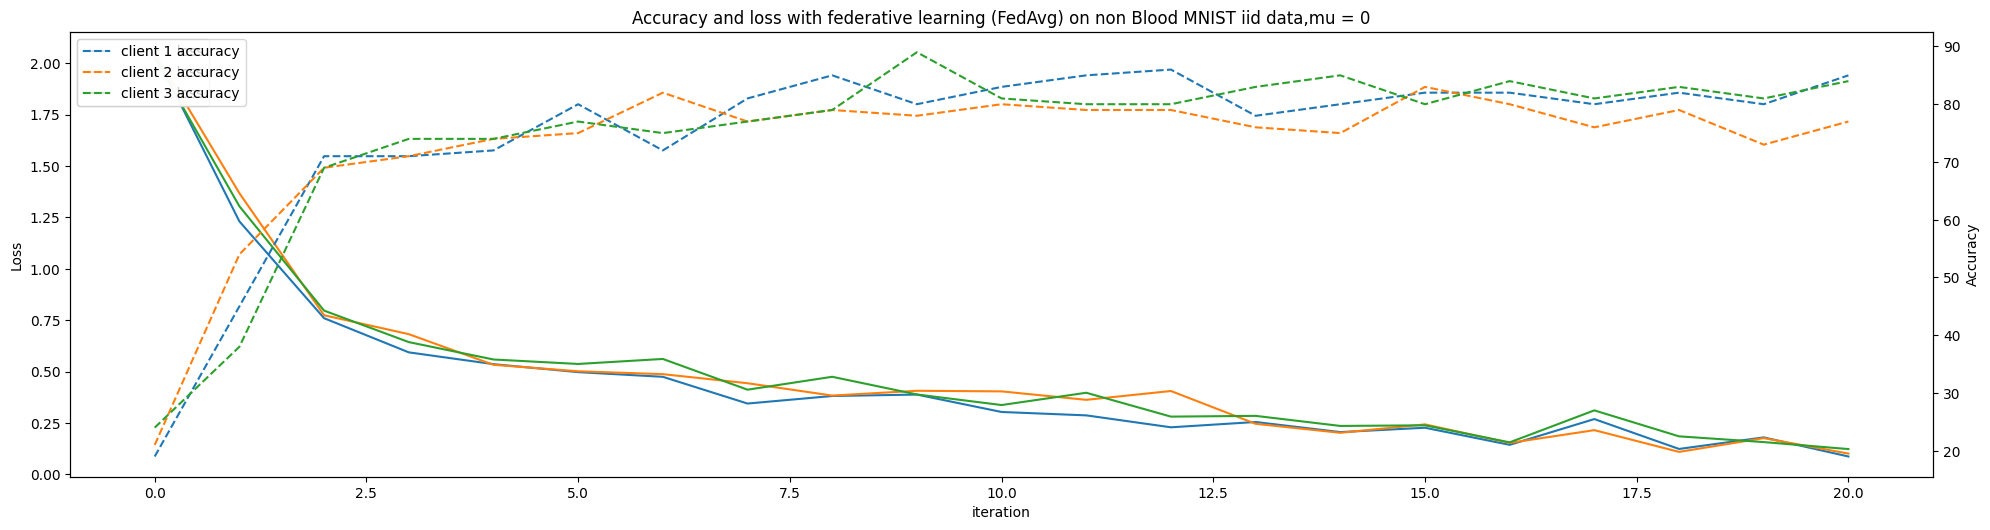

In [288]:
model_0 = CNN_2()
mu=0
fpx_model, loss_hist, acc_hist = FedProx(model_0,bmnist_iid_train,20,bmnist_iid_test,epochs=2,lr=0.1)
plot_acc_loss(f'Accuracy and loss with federative learning (FedAvg) on non Blood MNIST iid data,{mu = }',loss_hist,acc_hist )

### FedPRox

5. As FedAvg perform a FedProx on iid data. Keep the same µ.

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.075911521911621 Server Test Accuracy: 14.666666666666666
====> i: 1 Loss: 1.2778455813725789 Server Test Accuracy: 57.0
====> i: 2 Loss: 0.8662704428037007 Server Test Accuracy: 68.0
====> i: 3 Loss: 0.8027391036351521 Server Test Accuracy: 69.66666666666666
====> i: 4 Loss: 0.7245055635770161 Server Test Accuracy: 68.66666666666666
====> i: 5 Loss: 0.6129391392072041 Server Test Accuracy: 71.33333333333333
====> i: 6 Loss: 0.4971174001693725 Server Test Accuracy: 76.0
====> i: 7 Loss: 0.5282156268755595 Server Test Accuracy: 72.66666666666666
====> i: 8 Loss: 0.43119910359382624 Server Test Accuracy: 76.0
====> i: 9 Loss: 0.3796040117740631 Server Test Accuracy: 79.33333333333333
====> i: 10 Loss: 0.3803021113077799 Server Test Accuracy: 78.33333333333333


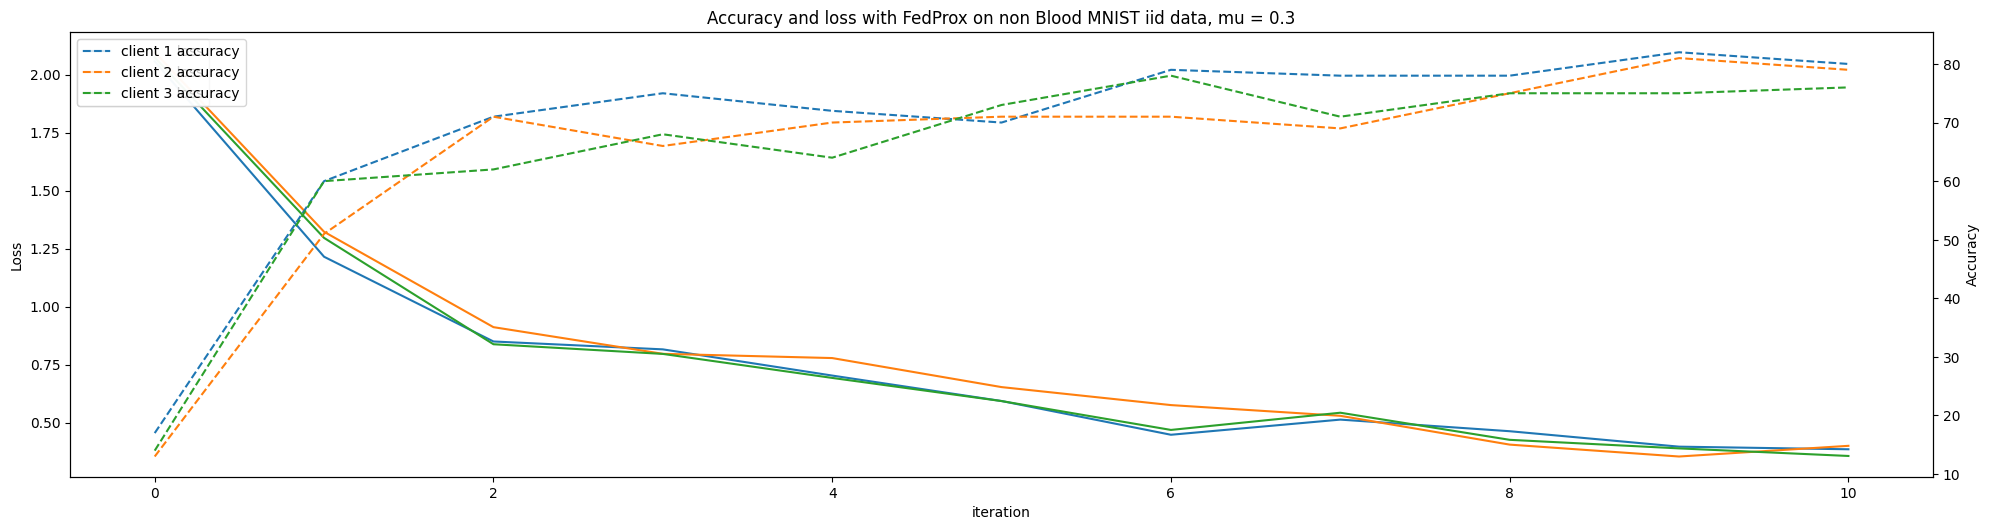

In [289]:
model_0 = CNN_2()
mu=0.3
fpx_model, loss_hist, acc_hist = FedProx(model_0,bmnist_iid_train,10,bmnist_iid_test,epochs=2,lr=0.1,mu=mu)
plot_acc_loss(f'Accuracy and loss with FedProx on non Blood MNIST iid data, {mu = }',loss_hist,acc_hist )

### MNIST Non iid

6. Do the same process (FedAVG, FedProx, plot loss and accuracy) but this time on non iid data.

Clients' weights: [0.33, 0.34, 0.33]
====> i: 0 Loss: 2.152503263950348 Server Test Accuracy: 16.532736950879556
====> i: 1 Loss: 1.5883431029319766 Server Test Accuracy: 47.743901999423244
====> i: 2 Loss: 1.3340444338321686 Server Test Accuracy: 51.8580577717966
====> i: 3 Loss: 1.1172742128372193 Server Test Accuracy: 67.82972459867347
====> i: 4 Loss: 1.1494527506828307 Server Test Accuracy: 56.993892987599736
====> i: 5 Loss: 1.1766414105892182 Server Test Accuracy: 52.905111506296265
====> i: 6 Loss: 0.8676009032130241 Server Test Accuracy: 72.7269838027492
====> i: 7 Loss: 0.7068029484152795 Server Test Accuracy: 71.53578595116794
====> i: 8 Loss: 0.7553904137015343 Server Test Accuracy: 69.23520258579256
====> i: 9 Loss: 1.1631223809719087 Server Test Accuracy: 51.25404330481592
====> i: 10 Loss: 1.4801745479553938 Server Test Accuracy: 40.61663702778045


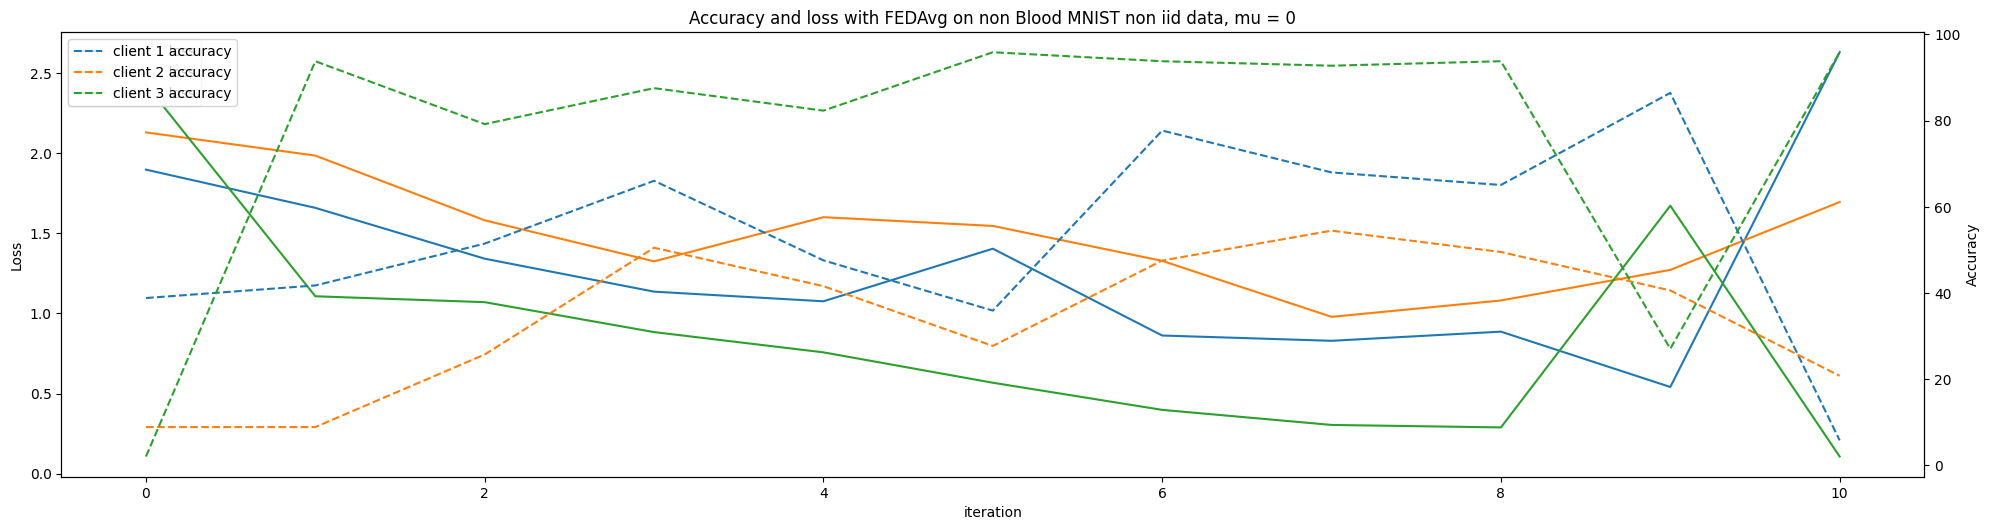

In [290]:
model_0 = CNN_2()
mu=0
fpx_model, loss_hist, acc_hist = FedProx(model_0,bmnist_non_iid_train,10,bmnist_non_iid_test,epochs=2,lr=0.1,mu=0)
plot_acc_loss( f'Accuracy and loss with FEDAvg on non Blood MNIST non iid data, {mu = }',loss_hist,acc_hist)

Clients' weights: [0.33, 0.34, 0.33]
====> i: 0 Loss: 2.071004768610001 Server Test Accuracy: 12.254022277227724
====> i: 1 Loss: 1.7421380043029786 Server Test Accuracy: 26.843131188118818
====> i: 2 Loss: 1.6680899631977084 Server Test Accuracy: 29.52652780447948
====> i: 3 Loss: 1.4275610733032227 Server Test Accuracy: 55.99974466500048
====> i: 4 Loss: 1.2441570127010346 Server Test Accuracy: 54.429215130250896
====> i: 5 Loss: 1.1162995737791062 Server Test Accuracy: 59.707818658079404
====> i: 6 Loss: 1.089984394311905 Server Test Accuracy: 60.09981195328271
====> i: 7 Loss: 1.092520341873169 Server Test Accuracy: 54.919809790445065
====> i: 8 Loss: 1.0096505904197692 Server Test Accuracy: 60.220645486878794
====> i: 9 Loss: 0.9558127564191818 Server Test Accuracy: 64.43089733730655
====> i: 10 Loss: 0.7996446031332016 Server Test Accuracy: 66.2953625156205


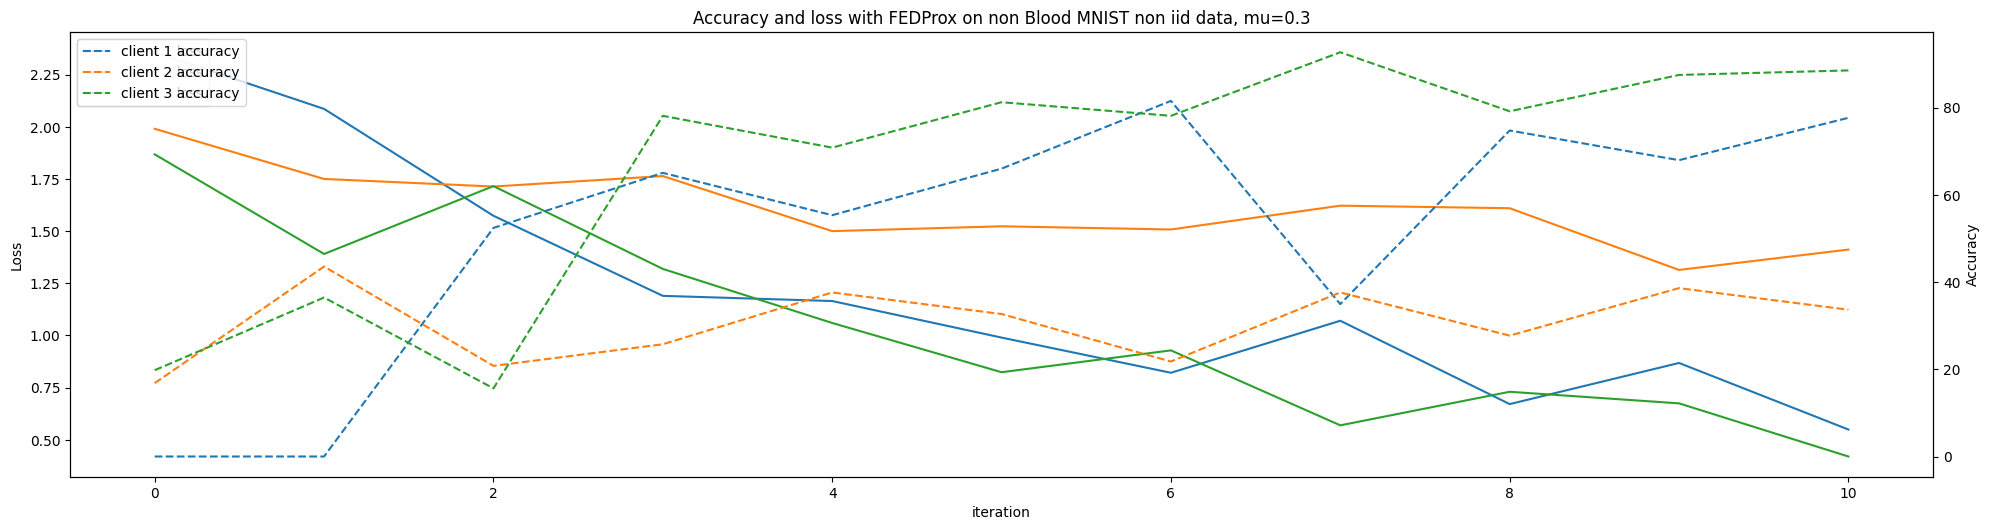

In [291]:
model_0 = CNN_2()
mu=0.3
fpx_model, loss_hist, acc_hist = FedProx(model_0,bmnist_non_iid_train,10,bmnist_non_iid_test,epochs=2,lr=0.1,mu=mu)
plot_acc_loss(f'Accuracy and loss with FEDProx on non Blood MNIST non iid data,{ mu=}',loss_hist,acc_hist)

7. Is results satisfying ? Submit some way to improve results and resolve possible unstabilities. For this you can check original paper : https://arxiv.org/pdf/1812.06127.pdf

For non-iid data results are quite disapointing whereas for iid data the result are not perfects in terms of accuracy or loss but their evolutions are smoother.